# <font color= 008000 > What is MRI ?

Magnetic Resonance Imaging (MRI) is a non-invasive imaging technology that produces three dimensional detailed anatomical images. It is often used for disease detection, diagnosis, and treatment monitoring. It is based on sophisticated technology that excites and detects the change in the direction of the rotational axis of protons found in the water that makes up living tissues.

# <font color= 008000 > How does MRI work ?

MRIs employ powerful magnets which produce a strong magnetic field that forces protons in the body to align with that field. When a radiofrequency (RF) current is then pulsed through the patient, the protons are stimulated, and spin out of equilibrium, straining against the pull of the magnetic field. When the radiofrequency field is turned off, the protons realign and emits that RF energy, the MRI sensors are able to detect this energy. Check out [Here](https://youtu.be/1CGzk-nV06g). Fourier transformation is used to convert the frequency information contained in the signal from each location in the imaged plane to corresponding intensity levels, which are then displayed as shades of gray in a matrix arrangement of pixels. By varying the sequence of RF pulses applied & collected, different types of images are created. Repetition Time (TR) is the amount of time between successive pulse sequences applied to the same slice. Time to Echo (TE) is the time between the delivery of the RF pulse and the receipt of the echo signal.

Tissue can be characterized by two different relaxation times – T1 and T2. T1 (longitudinal relaxation time) is the time constant which determines the rate at which excited protons return to equilibrium. It is a measure of the time taken for spinning protons to realign with the external magnetic field. T2 (transverse relaxation time) is the time constant which determines the rate at which excited protons reach equilibrium or go out of phase with each other. It is a measure of the time taken for spinning protons to lose phase coherence among the nuclei spinning perpendicular to the main field.

**MR Image sequences**
    
The most common MRI sequences are T1-weighted and T2-weighted scans. T1-weighted images are produced by using short TE and TR times. The contrast and brightness of the image are predominately determined by T1 properties of tissue. Conversely, T2-weighted images are produced by using longer TE and TR times. In these images, the contrast and brightness are predominately determined by the T2 properties of tissue.

In general, T1- and T2-weighted images can be easily differentiated by looking the CSF. CSF is dark on T1-weighted imaging and bright on T2-weighted imaging.

A third commonly used sequence is the Fluid Attenuated Inversion Recovery (Flair). The Flair sequence is similar to a T2-weighted image except that the TE and TR times are very long. By doing so, abnormalities remain bright but normal CSF fluid is attenuated and made dark. This sequence is very sensitive to pathology and makes the differentiation between CSF and an abnormality much easier. The most common sequence for brain tumor detection is Contrast Enhanced T1 weighted MRI. In our project the dataset has 4 channels images (T1,T2,T1ce,Flair)


# <font color= 008000 > What is MRI used for ?

MRI scanners are particularly well suited to image the non-bony parts or soft tissues of the body. They differ from computed tomography (CT), in that they do not use the damaging ionizing radiation of x-rays. The brain, spinal cord and nerves, as well as muscles, ligaments, and tendons are seen much more clearly with MRI than with regular x-rays and CT; for this reason MRI is often used to image knee and shoulder injuries.

# <font color= 008000 > What I will do in this project ?

My main task in this project is to perform a semantic segmentation of Brain MRI image using 3D U-net. I am using the images from BraTS2020 Data set. For accessing the dataset click
[here](https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation). 
    
### <font color='289C4E'>Table of contents<font><a class='anchor' id='top'></a>
1. [Importing Libraries](#pytorch)
2. [MR Image Exploration](#utility)
3. [Custom DataGenerator](#dt)  
4. [Sanity Check of DataGenerator output](#cg)  
5. [Losses and Metrics](#lm) 
6. [Training](#tr)
7. [End Notes](#e)  
# <font color= 008000 > Description of the Dataset
<div style="width:100%;text-align: center;"> <img align=middle src="https://www.dropbox.com/scl/fi/rwdbrgyaws75kgdbx0k23/BraTS.jpg?rlkey=pzxawc3x7irhvp80irknsoj4v&raw=1" alt="Heat beating" style="height:600px;margin-top:3rem;"> </div>
<center>
    
In the seg file we have label annotations. In numerical values pixels having 0 is not a tumor region. 1 is Necrotic and Non Enhancing Tumor core, 2. Edema, They didn't assign anything with label 3. 4 for Enhancing Tumor. We will later assign 4 with 3. 

# <font color='289C4E'> 1. Importing Libraries <a class='anchor' id='pytorch'></a> [↑](#top)
Below are the required libraries.
* Because the images are NIfTI files tensorflow can't read them. So we need some neuroimaging library [nibabel](https://nipy.org/nibabel/), [Nilearn](https://nilearn.github.io/stable/index.html)
* For training purpose we will use segmentation models 3d package [segmentation-models-3D 1.0.4](https://pypi.org/project/segmentation-models-3D/). It has UNet architecture ready, so we don't have to write from scratch.

In [1]:
! pip install -U nilearn
! pip install segmentation-models-3D
! pip install classification-models-3D
! pip install visualkeras
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import os
#General Libraries

import shutil
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#Model libraries
import tensorflow as tf
from tensorflow import keras
import visualkeras
from keras.utils.vis_utils import plot_model
import segmentation_models_3D as sm
from keras import callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

TRAIN_DATASET_PATH='/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 73.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.10.1
    Uninstalling nilearn-0.10.1:
      Successfully uninstalled nilearn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 96.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 46.7 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 5.6 MB/s eta 0:00:0000:01
  At

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Segmentation Models: using `tf.keras` framework.


#  <font color= 008000 >2. MR Image Exploration <a class='anchor' id='utility'></a> [↑](#top)

In [2]:
#get the list of all folders. Exclude 'BraTS20_Training_355'. As its segmenation image has some weired name.
Data_dir = [f.path for f in os.scandir('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData') if f.is_dir()]
def Name(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x
n=Name(Data_dir)
N=[t for t in n if t!='BraTS20_Training_355']#This file has weird seg name

In [3]:
class Image_explorer:
    def __init__(self):
        np.random.seed(4)
        i=np.random.randint(0,len(N)-1)
        path=os.path.join(TRAIN_DATASET_PATH,N[i])
        p=os.listdir(path)
        t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
        t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
        t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
        seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
        flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
        self.test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
        self.test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
        self.test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
        self.test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
        self.test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

    def Axial_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(self.test_image_flair[:,:,layer], cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(self.test_image_t1[:,:,layer], cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(self.test_image_t1ce[:,:,layer], cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(self.test_image_t2[:,:,layer], cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(self.test_seg[:,:,layer])
        ax5.set_title('Segmented')
        fig.suptitle('Axial View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Sagittal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[layer,:,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[layer,:,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[layer,:,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[layer,:,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[layer,:,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Sagittal View',fontsize=30)
        fig.tight_layout()
        plt.show()

    def Coronal_View(self,layer):
        fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 5))
        ax1.imshow(np.rot90(self.test_image_flair[:,layer,:]), cmap = 'gray')
        ax1.set_title('Flair')
        ax2.imshow(np.rot90(self.test_image_t1[:,layer,:]), cmap = 'gray')
        ax2.set_title('T1')
        ax3.imshow(np.rot90(self.test_image_t1ce[:,layer,:]), cmap = 'gray')
        ax3.set_title('T1ce')
        ax4.imshow(np.rot90(self.test_image_t2[:,layer,:]), cmap = 'gray')
        ax4.set_title('T2')
        ax5.imshow(np.rot90(self.test_seg[:,layer,:]))
        ax5.set_title('Segmented')
        fig.suptitle('Coronal View',fontsize=30)
        fig.tight_layout()
        plt.show()

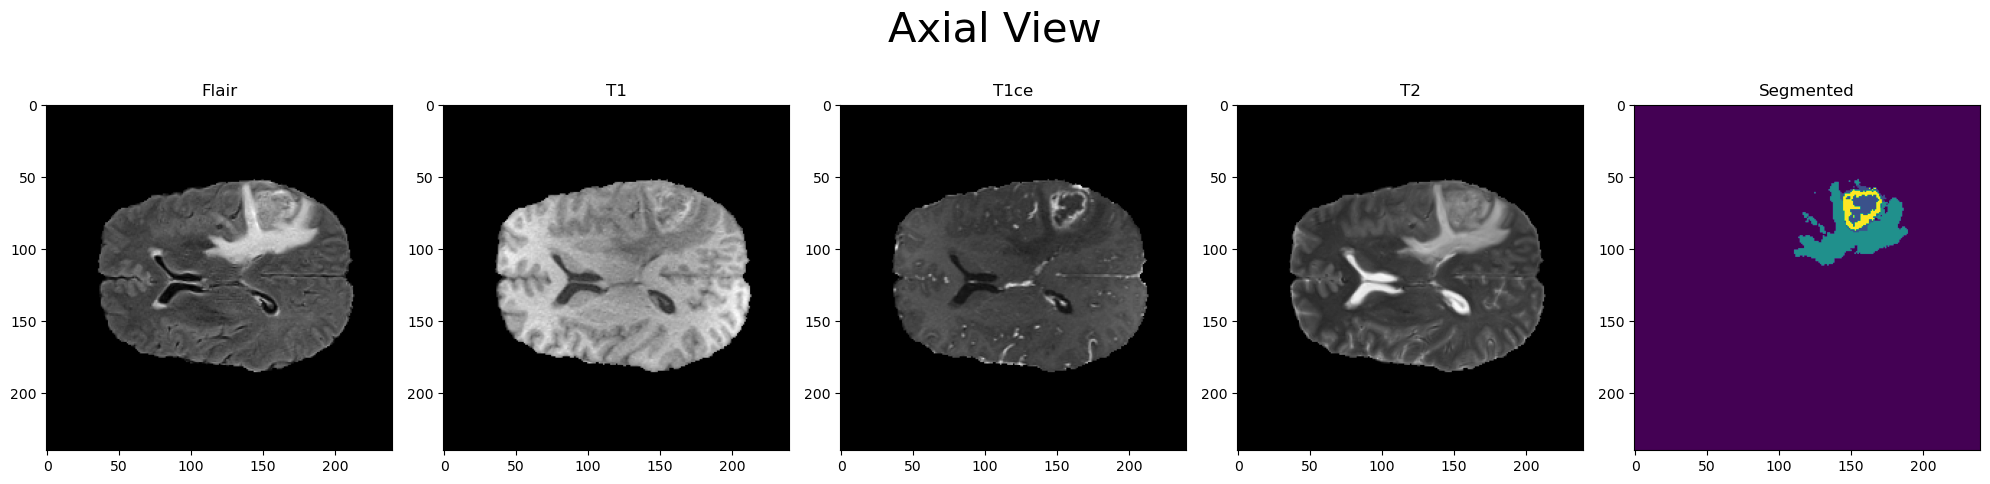

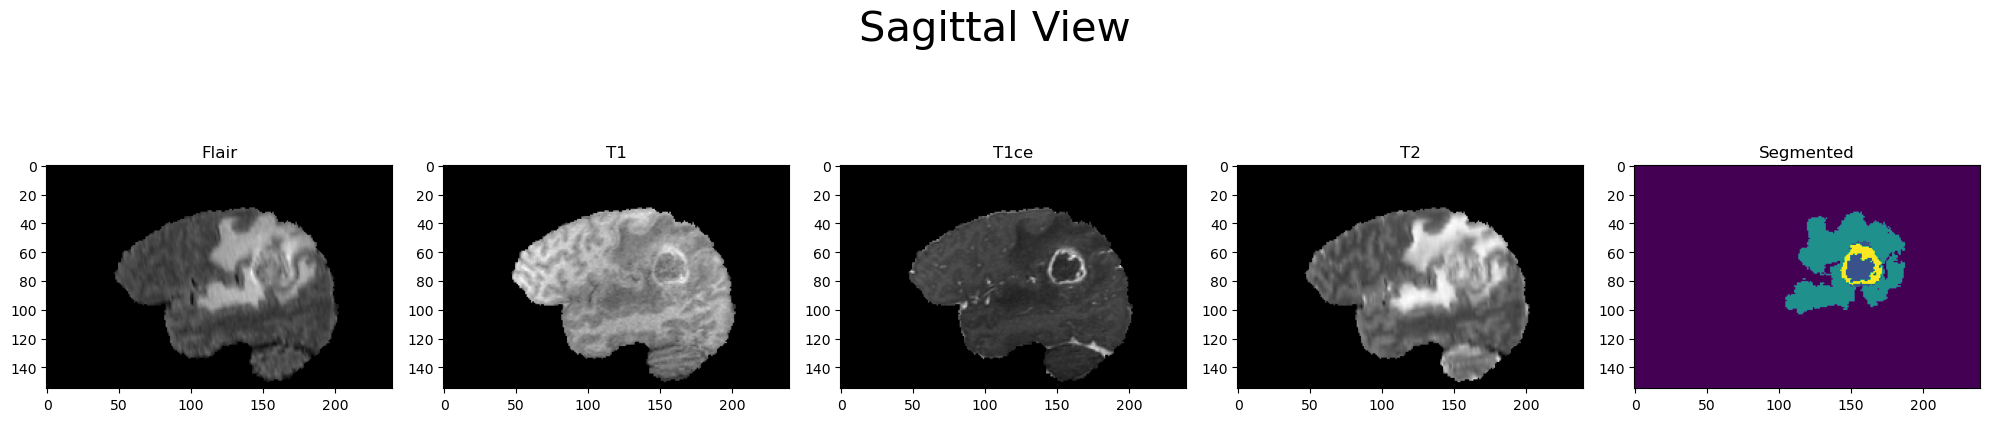

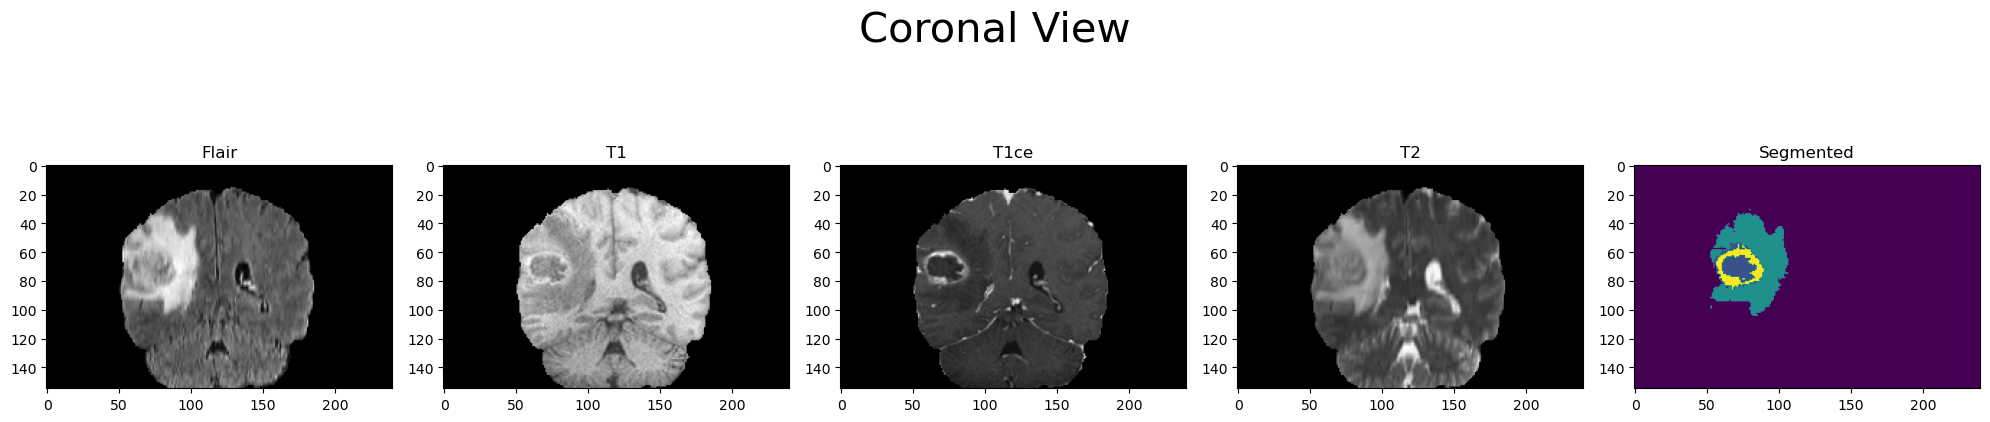

In [4]:
test_image_flair=nib.load('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
Image=Image_explorer
Image().Axial_View(layer=75);
Image().Sagittal_View(layer=75)
Image().Coronal_View(layer=150)

# <font color='289C4E'> 3. Custom DataGenerator <a class='anchor' id='dt'></a> [↑](#top)
As mentioned already tensorflow can't read the nifti files. So we can't use their inbuilt ImageDataGenerator. But Keras has its cutom data generator pipeline in its utils.Sequence Module. Some part of code I am motivated from [here](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly). We have to follow this exact pipeline and can change the __data_generation function as per our requirement.

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_IDs, batch_size=1, dim=(128,128,128),shuffle=False,channels=3,num_class=4):
        'Initialization'
        self.dim = dim
        self.n_channels=channels
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.num_class=num_class
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Generate data
        X=np.zeros((self.batch_size,*(self.dim),self.n_channels))
        Y=np.zeros((self.batch_size,*(self.dim),self.num_class))
        for i, ID in enumerate(list_IDs_temp):
            case_path = os.path.join(TRAIN_DATASET_PATH, ID)
            data_path = os.path.join(case_path, f'{ID}_t1.nii')
            t1 = nib.load(data_path).get_fdata()
            st1=MinMaxScaler()
            t1=st1.fit_transform(t1.reshape(-1,t1.shape[-1])).reshape(t1.shape)
            data_path = os.path.join(case_path, f'{ID}_flair.nii')
            flair = nib.load(data_path).get_fdata()
            stflair=MinMaxScaler()
            flair=stflair.fit_transform(flair.reshape(-1,flair.shape[-1])).reshape(flair.shape)
            data_path = os.path.join(case_path, f'{ID}_t1ce.nii')
            t1ce = nib.load(data_path).get_fdata()
            st1ce=MinMaxScaler()
            t1ce=st1ce.fit_transform(t1ce.reshape(-1,t1ce.shape[-1])).reshape(t1ce.shape)
            data_path = os.path.join(case_path, f'{ID}_seg.nii')
            seg = nib.load(data_path)
            x=np.stack([t1,flair,t1ce],axis=3)
            seg=np.array(seg.get_fdata())
            seg[seg==4]=3
            seg=keras.utils.to_categorical(seg,self.num_class)
            X[i]=x[56:184,56:184,13:141]#this slicing is important as GPU will run out of memory if we take the complete image
            Y[i]=seg[56:184,56:184,13:141]

        return X, Y

In [6]:
Train_ids = Name(Data_dir);
Train_ids=[t for t in Train_ids if t!='BraTS20_Training_355']
train,test=train_test_split(Train_ids,test_size=(1/4),random_state=42)
Train,Validation=train_test_split(train,test_size=(1/4),random_state=42)
Train_datagen=DataGenerator(Train,batch_size=1)
Val_datagen=DataGenerator(Validation,batch_size=1)

# <font color='289C4E'>4. Sanity Check of DataGenerator output <a class='anchor' id='cg'></a> [↑](#top)

In [11]:
X,y=Train_datagen.__getitem__(10)

In [12]:
print(X.shape)
print(y.shape)

(1, 128, 128, 128, 3)
(1, 128, 128, 128, 4)


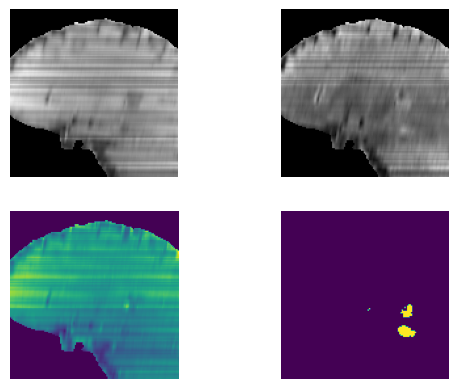

In [15]:
sample=0#checking the 2nd sample of first batch
yhat=y[sample]
yhat=np.argmax(yhat,axis=-1)
layer=80
plt.subplot(2,2,1)
plt.imshow(np.rot90(X[sample,layer,:,:,0]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(X[sample,layer,:,:,1]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(X[sample,layer,:,:,2]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

In [18]:
#original image
img_path=Train[1]
path=os.path.join(TRAIN_DATASET_PATH,img_path)
p=os.listdir(path)
t1 = [i for i, s in enumerate(p) if 't1.nii' in s]
t2 = [i for i, s in enumerate(p) if 't2.nii' in s]
t1ce = [i for i, s in enumerate(p) if 't1ce.nii' in s]
seg = [i for i, s in enumerate(p) if 'seg.nii' in s]
flair = [i for i, s in enumerate(p) if 'flair.nii' in s]
test_image_flair=nib.load(os.path.join(path,p[flair[0]])).get_fdata()
test_image_t1=nib.load(os.path.join(path,p[t1[0]])).get_fdata()
test_image_t1ce=nib.load(os.path.join(path,p[t1ce[0]])).get_fdata()
#test_image_t2=nib.load(os.path.join(path,p[t2[0]])).get_fdata()
test_seg=nib.load(os.path.join(path,p[seg[0]])).get_fdata()

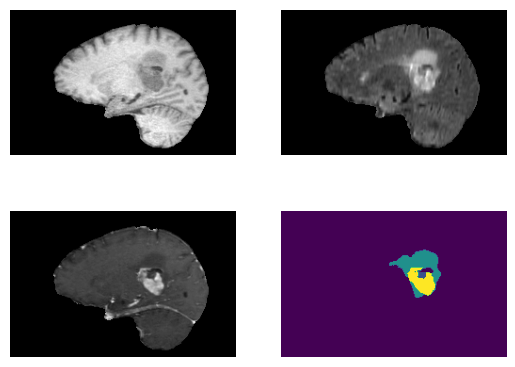

In [19]:
layer=136
plt.subplot(2,2,1)
plt.imshow(np.rot90(test_image_t1[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(test_image_flair[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(test_image_t1ce[layer,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(test_seg[layer,:,:]))
plt.axis('off')
plt.show()

# <font color='289C4E'>4. Losses and Metrics <a class='anchor' id='lm'></a> [↑](#top)
We will use a special loss function used in this domain called 

In [23]:
wt=np.array([0.25,0.25,0.25,0.25])
diceloss=sm.losses.DiceLoss(class_weights=wt)
focalloss=sm.losses.CategoricalFocalLoss()
totalloss=diceloss+(1*focalloss)
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

In [21]:
batch_size=1
lr=0.0001
optim=keras.optimizers.Adam(lr)
steps_per_epoch=len(Train)//batch_size
val_steps_per_epoch=len(Validation)//batch_size

In [ ]:
# model=sm.Unet(backbone_name='vgg16', input_shape=(128,128,128,3), classes=4, activation='softmax',encoder_weights='imagenet')
# model.compile(optimizer=optim,loss=totalloss,metrics=metrics)
# model.summary()

In [24]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

def conv_block(x, filters, kernel_size=(3, 3, 3), activation='relu', padding='same'):
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv3D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_3d(input_shape=(128, 128, 128, 3), num_classes=4):
    inputs = layers.Input(input_shape)

    # Encoder
    conv1 = conv_block(inputs, 32)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv3)

    # Middle
    conv4 = conv_block(pool3, 256)

    # Decoder
    up5 = layers.UpSampling3D(size=(2, 2, 2))(conv4)
    concat5 = layers.concatenate([conv3, up5], axis=-1)
    conv5 = conv_block(concat5, 128)

    up6 = layers.UpSampling3D(size=(2, 2, 2))(conv5)
    concat6 = layers.concatenate([conv2, up6], axis=-1)
    conv6 = conv_block(concat6, 64)

    up7 = layers.UpSampling3D(size=(2, 2, 2))(conv6)
    concat7 = layers.concatenate([conv1, up7], axis=-1)
    conv7 = conv_block(concat7, 32)

    outputs = layers.Conv3D(num_classes, (1, 1, 1), activation='softmax')(conv7)

    model = Model(inputs, outputs, name='3D_UNet')
    return model

# Instantiate the model
custom_model = unet_3d(input_shape=(128, 128, 128, 3), num_classes=4)

# Compile the model
custom_model.compile(optimizer=optim, loss=totalloss, metrics=metrics)

# Display model summary
custom_model.summary()


Model: "3D_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_30 (Conv3D)             (None, 128, 128, 12  2624        ['input_3[0][0]']                
                                8, 32)                                                            
                                                                                                  
 batch_normalization_28 (BatchN  (None, 128, 128, 12  128        ['conv3d_30[0][0]']              
 ormalization)                  8, 32)                                                      

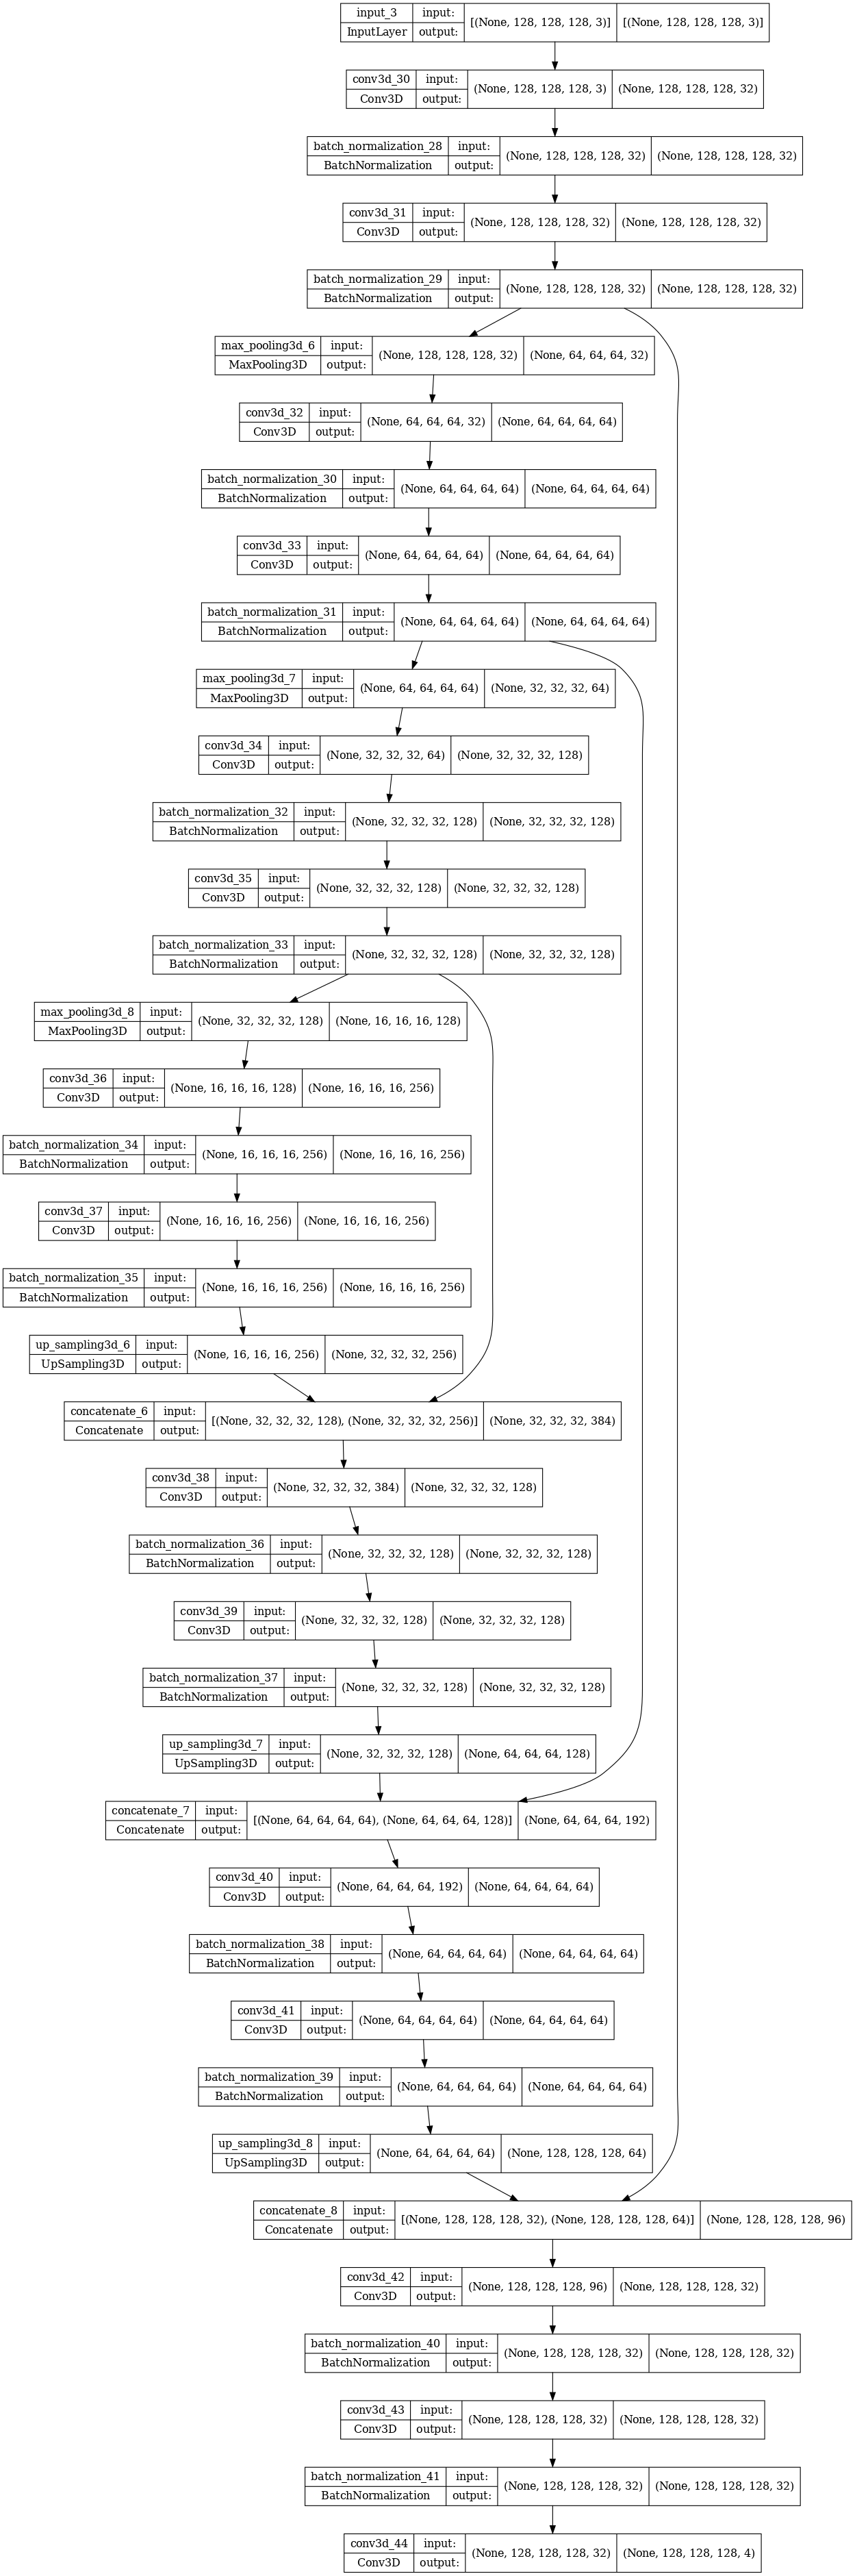

In [26]:
plot_model(custom_model, show_shapes = True,expand_nested = True,dpi = 80)

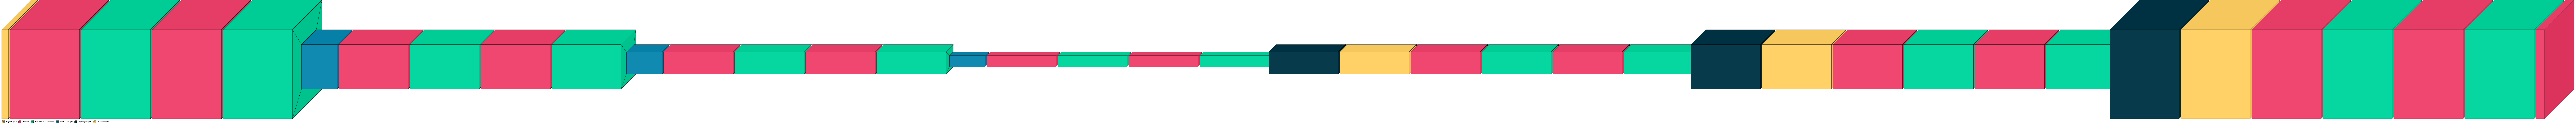

In [27]:
visualkeras.layered_view(custom_model, legend=True)

# <font color='289C4E'>5. Training <a class='anchor' id='tr'></a> [↑](#top)
**1st Round Training**

In [ ]:
history=custom_model.fit(Train_datagen,epochs=1,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch)
# model.save('my_mdl.keras')

**Higher Round trainings**

In [ ]:
# UNet_3D=load_model('/kaggle/input/unet3d-round2/UNet_3D_best_model_round2_128.keras',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
# UNet_3D.summary()

In [ ]:
# plot_model(UNet_3D, show_shapes = True,expand_nested = True,dpi = 80)

In [ ]:
# visualkeras.layered_view(UNet_3D, legend=True)

Note the actual model is trained on more than 100 epochs

In [ ]:
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# mc = ModelCheckpoint('UNet_3D_best_model_round3_128.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [ ]:
# #30epochs
# history=UNet_3D.fit(Train_datagen,epochs=40,validation_data=Val_datagen,verbose=1,steps_per_epoch=steps_per_epoch,validation_steps=val_steps_per_epoch,callbacks=[es,mc])
# #my_model.save('UNet_3D_128_128_128_round_1.keras')

In [ ]:
# UNet_3D=load_model('/kaggle/input/trained-unet-3d/UNet_3D_best_model_round3_128.keras',custom_objects={'dice_loss_plus_1focal_loss':totalloss,'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [ ]:
plt.title('Train_accuracy')
plt.plot(history.history['accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.title('Validation_accuracy')
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
plt.title('Train_IOU_score')
plt.plot(history.history['iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

In [ ]:
plt.title('Validation_IOU_score')
plt.plot(history.history['val_iou_score'])
plt.xlabel('Epochs')
plt.ylabel('IOU Score')
plt.show()

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'],label='Train_loss')
plt.plot(history.history['val_loss'],label='Val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
X,y=Val_datagen.__getitem__(1)#fetching the first batch

In [ ]:
y_pred=model.predict(X)

In [ ]:
sample=0#checking the 2nd sample of first batch
yhat=y[sample]
yhat=np.argmax(yhat,axis=-1)
layer=80
plt.subplot(2,2,1)
plt.imshow(np.rot90(X[sample,layer,:,:,0]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.rot90(X[sample,layer,:,:,1]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.rot90(X[sample,layer,:,:,2]))
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

yhat=np.argmax(y_pred[0],axis=-1)
plt.imshow(np.rot90(yhat[layer,:,:]))
plt.axis('off')
plt.show()

In [ ]:
from IPython.display import FileLink
import os
os.chdir(r'/kaggle/working/')
FileLink(r'/kaggle/working/UNet_3D_best_model_round3_128.keras')